In [1]:
import os
import _init_path
import numpy as np
from skimage import morphology
from skimage import feature
from skimage import measure
import math
from matplotlib import pyplot as plt
import cv2

from params import param
import tools
%matplotlib inline 

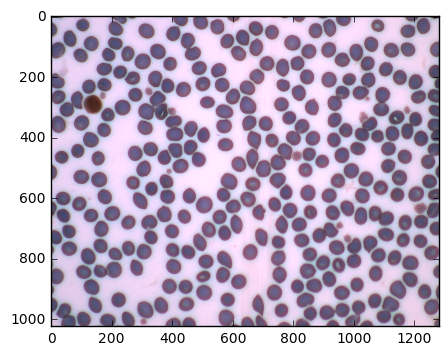

In [2]:
param=param()
    
image_dir=param.getTestImageDirs('Lymphocyte')
image_file=os.path.join(image_dir,'23.bmp')
im = cv2.imread(image_file,cv2.IMREAD_COLOR)
plt.imshow(im)


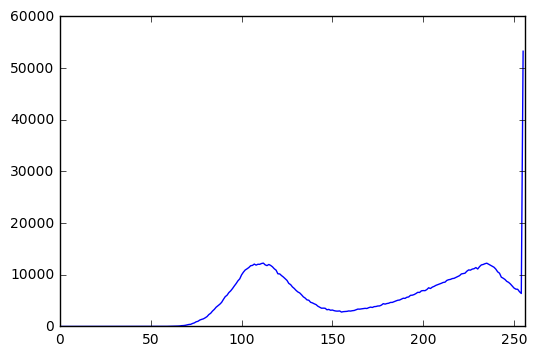

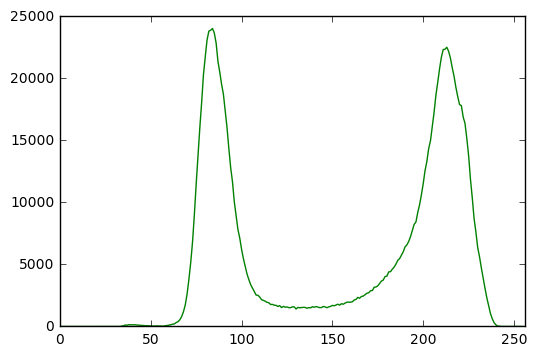

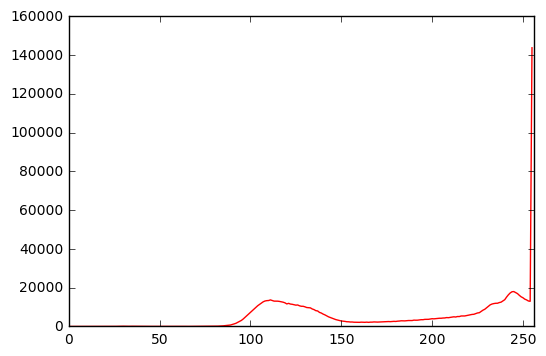

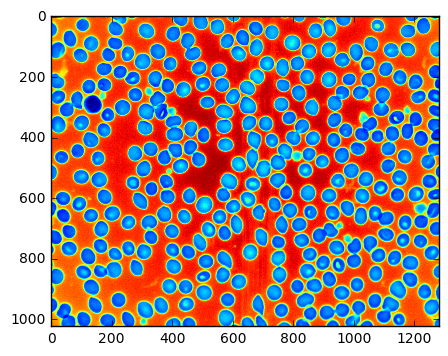

In [3]:
hist = tools.colorHist(im,1)
im_onech = im[:,:,1];
plt.imshow(im_onech)

In [4]:
th, foreground_mask = cv2.threshold(im_onech,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# processing for dtf

r=int(param.rbcR/2)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(r,r))

foreground_mask_open=cv2.morphologyEx(foreground_mask, cv2.MORPH_OPEN, kernel, iterations=1)

# filling convex holes

background_mask=255-foreground_mask_open

output = cv2.connectedComponentsWithStats(background_mask, 8, cv2.CV_32S)


for i in range(output[0]):
    area=output[2][i][4]
    if area<param.rbcR*param.rbcR/5: 
        foreground_mask_open[output[1]==i]=255


# use dtf to find markers for watershed
dist_transform = cv2.distanceTransform(foreground_mask_open,cv2.DIST_L2,5)

dist_transform[dist_transform<param.rbcR*0.5]=0

# watershed
r=int(param.rbcR/2)
kernel = np.ones((r,r),np.uint8)

local_maxi = feature.peak_local_max(dist_transform, indices=False, footprint=np.ones((int(param.rbcR*0.6), int(param.rbcR*0.6))), labels=foreground_mask_open)
local_maxi_dilate=cv2.dilate(local_maxi.astype('uint8')*255,kernel, iterations = 1)
markers = measure.label(local_maxi_dilate)


# watershed on dtf
labels_ws = morphology.watershed(-dist_transform, markers, mask=foreground_mask_open)

# edge map for visualization
mag = tools.getGradientMagnitude(labels_ws.astype('float32'))
mag[mag>0]=255

im2=tools.maskOverlay(im,mag,0.5,1,0)
cv2.namedWindow('detected')
# counting

for label in np.unique(labels_ws):
        # if the label is zero, we are examining the 'background'
        # so simply ignore it
     if label == 0:
         continue

     mask = np.zeros(im_onech.shape, dtype="uint8")
     mask[labels_ws == label] = 255
     cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[-2]
     c = max(cnts, key=cv2.contourArea)
     x,y,w,h = cv2.boundingRect(c)
     if ((x>param.rbcR) & (x+w<im.shape[1]-param.rbcR) & 
         (y>param.rbcR) & (y+h<im.shape[0]-param.rbcR)):
        cv2.rectangle(im2,(x,y),(x+w,y+h),(255,255,255),2)
        cv2.putText(im2, "#{}".format(label), (x - 10, y),cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2) 
        if cv2.contourArea(c)>2*int(math.pi*math.pow(param.wbcRatio*param.rbcR,2)):
            cv2.rectangle(im2,(x,y),(x+w,y+h),(0,0,255),3)
cv2.imshow('detected',im2)    
cv2.waitKey()

-1